# Importing required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import roc_auc_score
from tabulate import tabulate


In [2]:
df = pd.read_csv('../data/cleaned_xente_data.csv')

In [3]:
# Data Preparation: Check the structure of the DataFrame
print("Dataset Shape:", df.shape)
print("Data Types:\n", df.dtypes)

Dataset Shape: (95662, 16)
Data Types:
 TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object


# Define RFMS calculation function


In [4]:
import pandas as pd

def calculate_rfms(df):
    """
    Function to calculate RFMS score for each user.
    RFMS (Recency, Frequency, Monetary, Score) - Higher values indicate better customers.
    """
    # Ensure TransactionStartTime is in datetime format
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

    # Strip timezone info if present to make it timezone-naive
    if df['TransactionStartTime'].dt.tz is not None:
        df['TransactionStartTime'] = df['TransactionStartTime'].dt.tz_localize(None)

    # Calculate Recency
    recency = df.groupby('CustomerId')['TransactionStartTime'].max().reset_index()
    recency['Recency'] = (pd.to_datetime('today') - recency['TransactionStartTime']).dt.days
    recency = recency[['CustomerId', 'Recency']]

    # Calculate Frequency
    frequency = df.groupby('CustomerId')['TransactionId'].count().reset_index()
    frequency.columns = ['CustomerId', 'Frequency']

    # Calculate Monetary
    monetary = df.groupby('CustomerId')['Amount'].sum().reset_index()
    monetary.columns = ['CustomerId', 'Monetary']

    # Merge all three dataframes
    rfms_df = recency.merge(frequency, on='CustomerId')
    rfms_df = rfms_df.merge(monetary, on='CustomerId')

    return rfms_df


In [5]:
print(df['TransactionStartTime'].dtype)


object


# Calculate RFMS score


In [6]:
rfms_df = calculate_rfms(df)

# Visualizing RFMS Space


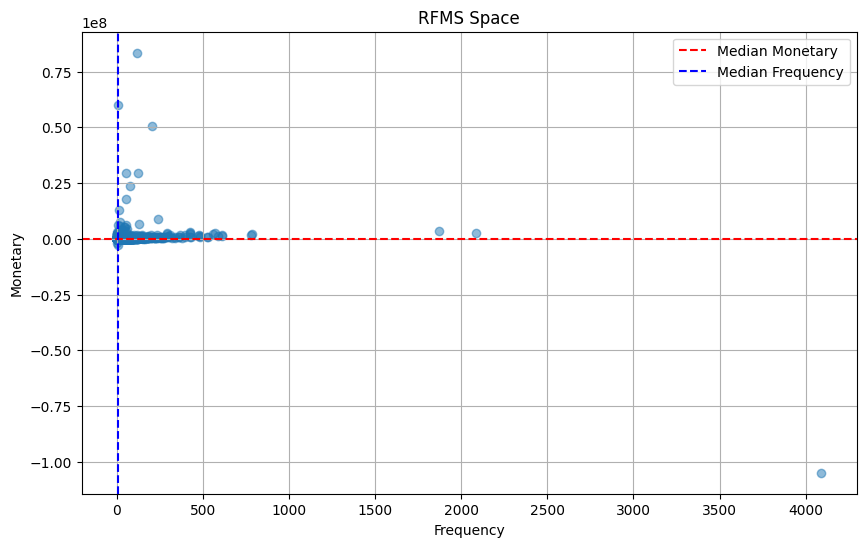

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(rfms_df['Frequency'], rfms_df['Monetary'], alpha=0.5)
plt.title('RFMS Space')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.grid()
plt.axhline(y=rfms_df['Monetary'].median(), color='r', linestyle='--', label='Median Monetary')
plt.axvline(x=rfms_df['Frequency'].median(), color='b', linestyle='--', label='Median Frequency')
plt.legend()
plt.show()

# Assigning Good and Bad Labels


In [8]:
median_frequency = rfms_df['Frequency'].median()
median_monetary = rfms_df['Monetary'].median()

rfms_df['Default_Estimator'] = np.where(
    (rfms_df['Frequency'] >= median_frequency) & (rfms_df['Monetary'] >= median_monetary), 'Good', 'Bad'
)

In [13]:
# Calculate the number of "Good" and "Bad" in the 'Default_Estimator' column
classification_counts = rfms_df['Default_Estimator'].value_counts()

# Display the counts
print(classification_counts)


Default_Estimator
Bad     2212
Good    1530
Name: count, dtype: int64


# Displaying distribution of Default Estimator


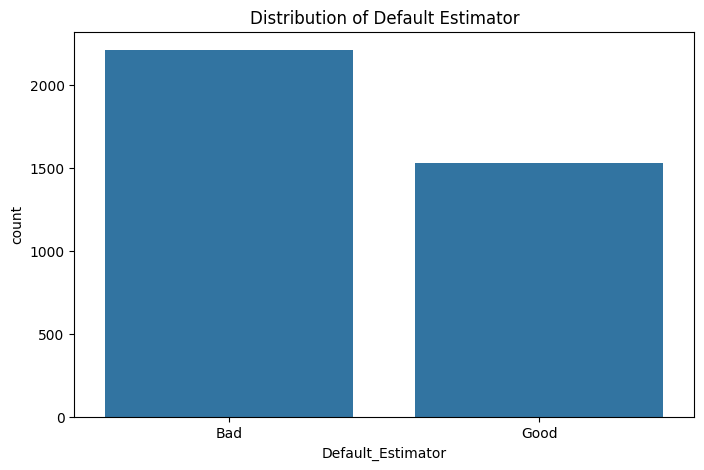

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Default_Estimator', data=rfms_df)
plt.title('Distribution of Default Estimator')
plt.show()

# Performing Weight of Evidence (WoE) Binning


In [11]:
def woe_binning(df, target_col, feature_col):
    """
    Function to perform Weight of Evidence (WoE) binning.
    """
    # Create a DataFrame for WoE calculation
    woe_df = df.groupby(feature_col)[target_col].agg(['count', 'sum']).reset_index()
    woe_df['Bad'] = woe_df['sum']  # Bad = Default = 1
    woe_df['Good'] = woe_df['count'] - woe_df['Bad']  # Good = Non-default = 0

    # Calculate WoE
    woe_df['Good'] = woe_df['Good'] / woe_df['Good'].sum()
    woe_df['Bad'] = woe_df['Bad'] / woe_df['Bad'].sum()
    
    # Avoid division by zero
    woe_df['WoE'] = np.where(woe_df['Bad'] == 0, 0, np.log(woe_df['Good'] / woe_df['Bad']))

    return woe_df[[feature_col, 'WoE']]


In [ ]:
# Apply WoE Binning
woe_result = woe_binning(rfms_df, 'Default_Estimator', 'RFMS')

# Output the WoE results
print(tabulate(woe_result, headers='keys', tablefmt='fancy_grid', showindex=False, stralign='center', numalign='right'))


In [38]:
# Save the RFMS and WoE results to a CSV file
rfms_df.to_csv('rfms_with_default_estimator.csv', index=False)
woe_result.to_csv('woe_results.csv', index=False)